# Imports

In [1]:
import warnings
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold

from dstoolkit.automl import AutoMLClassifier, AutoMLClassifierCV

/home/junior/Documentos/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

## Functions

In [3]:
def generate_synthetic_binary_data(
    n_samples=10000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,
    flip_y=0.15,
    weights=[0.8, 0.2],
    test_size=0.2,
    valid_size=0.2,
    random_state=42
):
    """
    Gera uma base sintética binária com splits train/valid/test.
    Retorna: (X_train, y_train, X_valid, y_valid, X_test, y_test)
    """

    # ---------------------------
    # 1. Gerar base sintética
    # ---------------------------
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_classes=n_classes,
        class_sep=class_sep,
        flip_y=flip_y,
        weights=weights,
        random_state=random_state
    )

    # ---------------------------
    # 2. Train/Test
    # ---------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # ---------------------------
    # 3. Train/Validation
    # ---------------------------
    valid_relative = valid_size / (1 - test_size)

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train,
        test_size=valid_relative,
        stratify=y_train,
        random_state=random_state
    )

    y_train = pd.DataFrame(y_train, columns=['target'])
    y_valid = pd.DataFrame(y_valid, columns=['target'])
    y_test = pd.DataFrame(y_test, columns=['target'])
    
    return pd.DataFrame(X_train), y_train, pd.DataFrame(X_valid), y_valid, pd.DataFrame(X_test), y_test

# Data Base

In [4]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_synthetic_binary_data(
    n_samples=5000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,   # classes mais misturadas
    flip_y=0.15,     # ruído nos rótulos
    weights=[0.8, 0.2],  # desbalanceamento
    test_size=0.2,
    valid_size=0.2,
    random_state=42
)


# Modeling

## HistGradientBoosting

In [5]:
hist = AutoMLClassifier(model_name='HistGradientBoosting', scoring='brier', tune=True, n_trials=50)
hist.train(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [6]:
hist.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train,0.843393,0.960674,0.696065,0.807238,0.989592,0.913650,0.059857,0.228786
Valid,0.716867,0.794521,0.473469,0.593350,0.807758,0.513340,0.126625,0.414003
Test,0.713355,0.734568,0.483740,0.583333,0.799276,0.510341,0.132781,0.429321


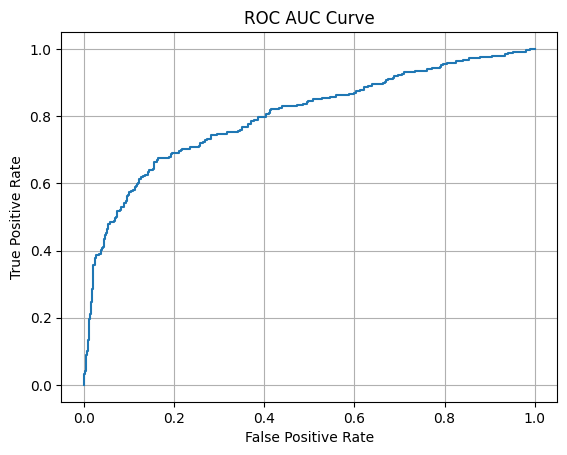

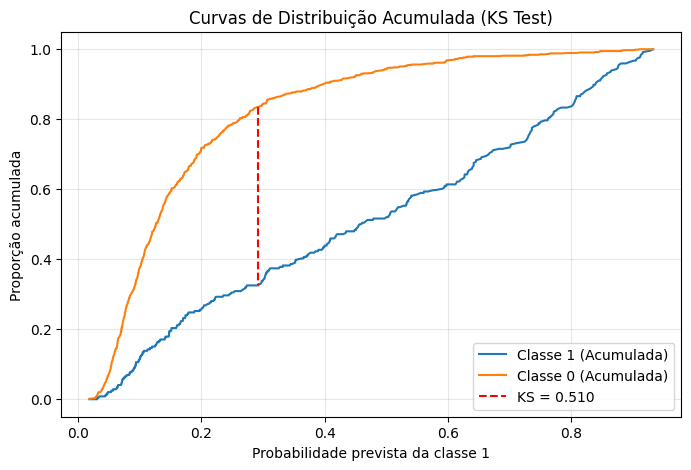

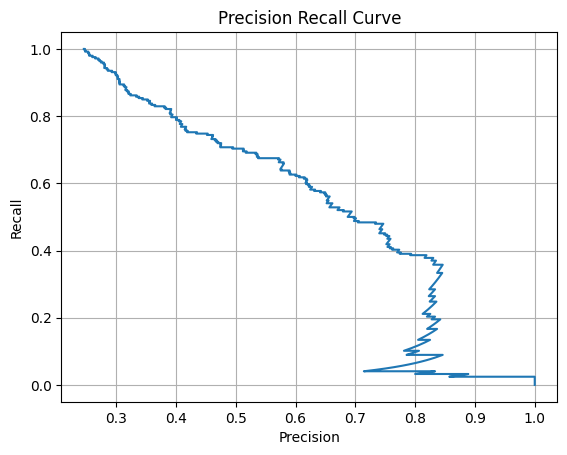

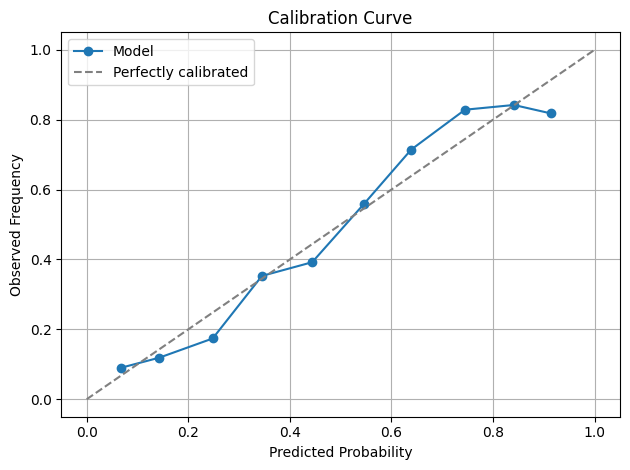

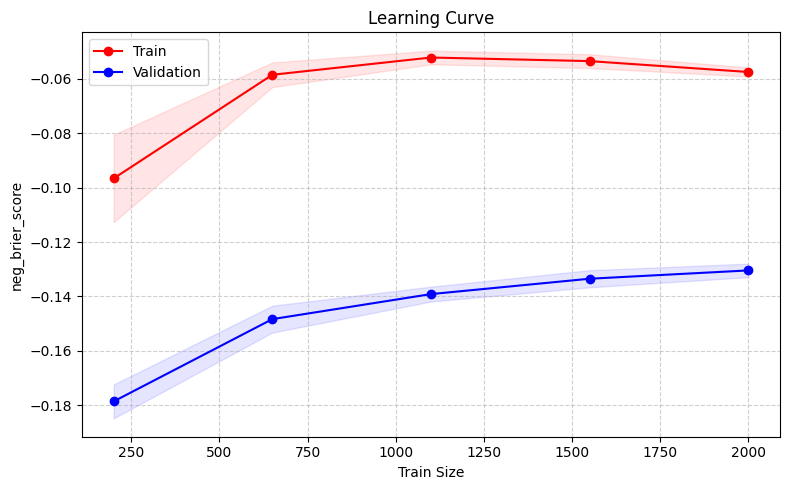

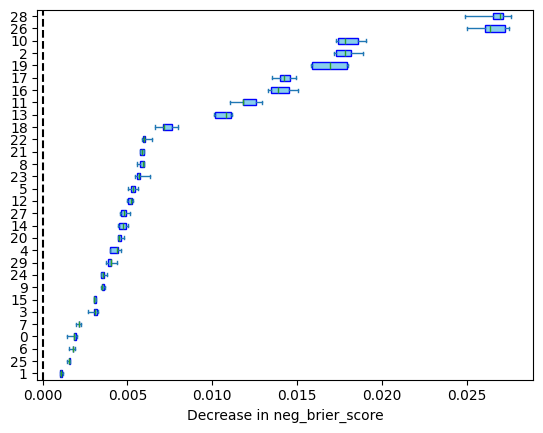

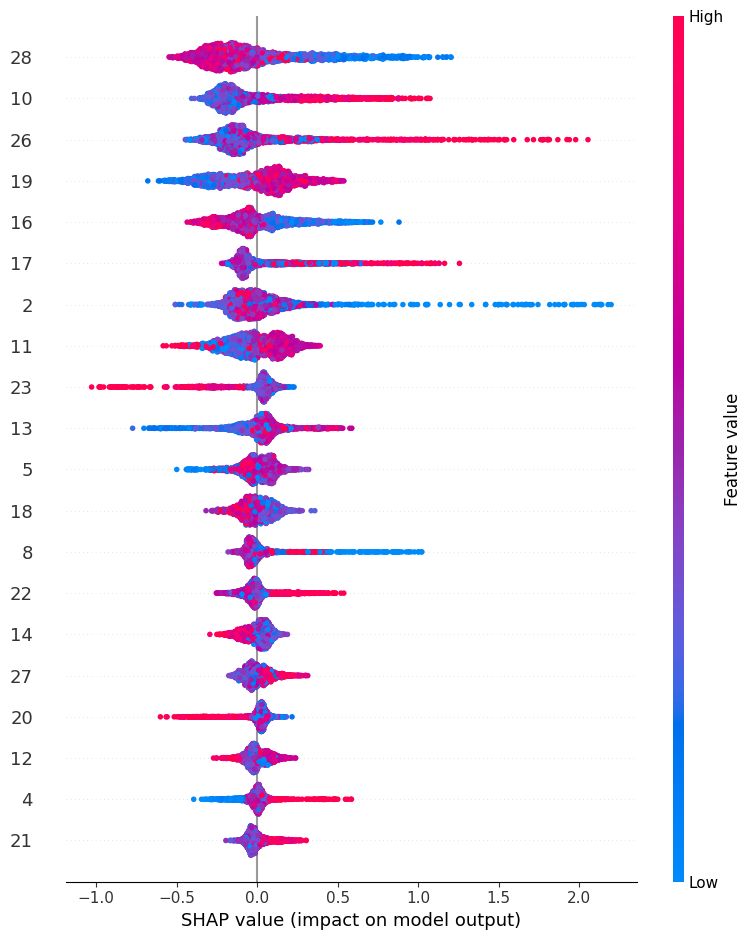

In [7]:
hist.analyze()

## LightGBM

In [8]:
selected_columns = list(set(np.random.choice(X_train.columns.tolist(), 20)))
selected_columns

[np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(5),
 np.int64(6),
 np.int64(12),
 np.int64(14),
 np.int64(15),
 np.int64(17),
 np.int64(19),
 np.int64(20),
 np.int64(22),
 np.int64(23),
 np.int64(26),
 np.int64(27),
 np.int64(28)]

In [9]:
lgbm = AutoMLClassifierCV(model_name='LightGBM', scoring='roc_auc', tune=True)
lgbm.train(X_train[selected_columns], y_train, X_test[selected_columns], y_test)

In [10]:
lgbm.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train CV,0.692425,0.776581,0.424618,0.548670,0.810498,NaN,0.131549,0.423875
Test,0.687062,0.677019,0.443089,0.535627,0.791130,0.516799,0.136858,0.438990


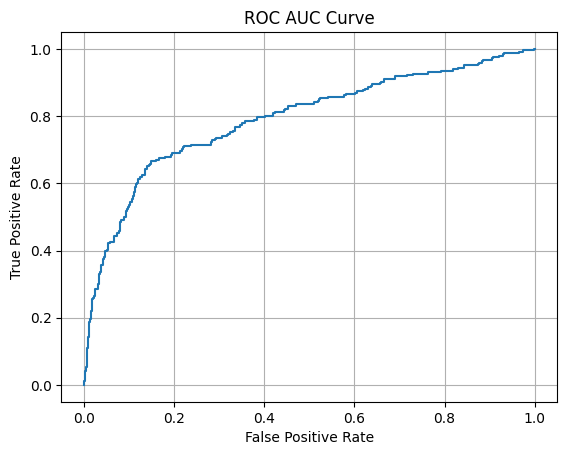

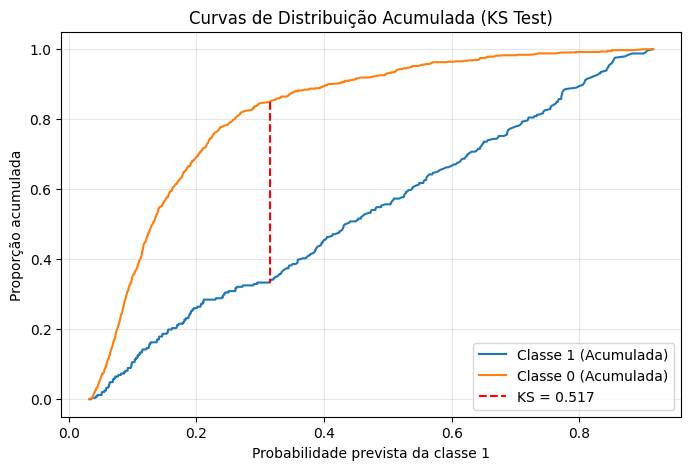

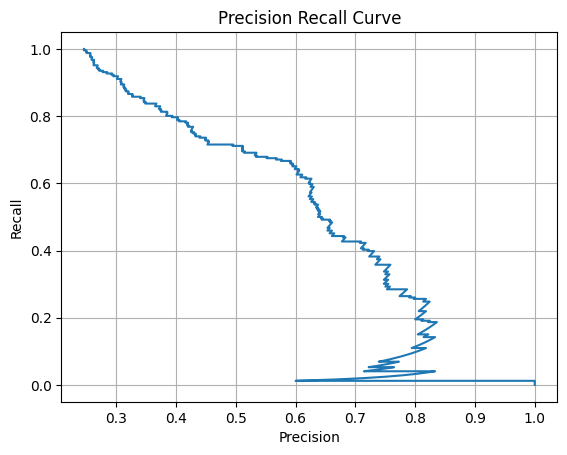

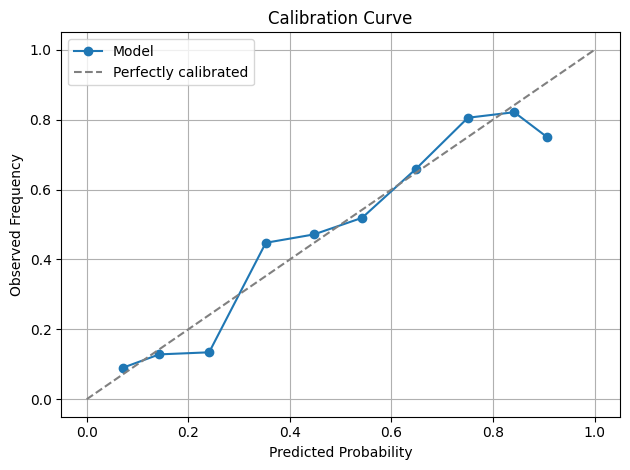

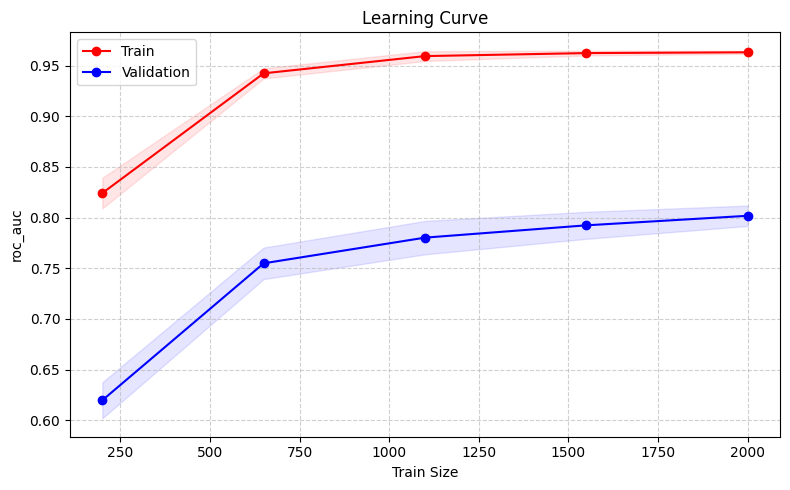

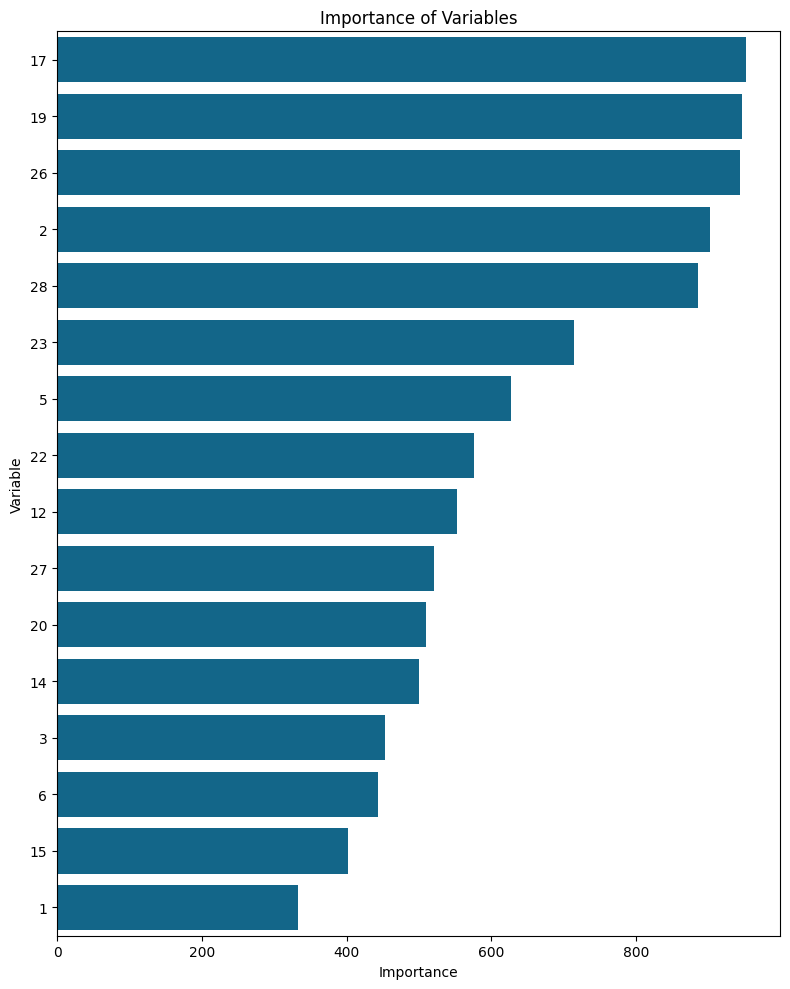

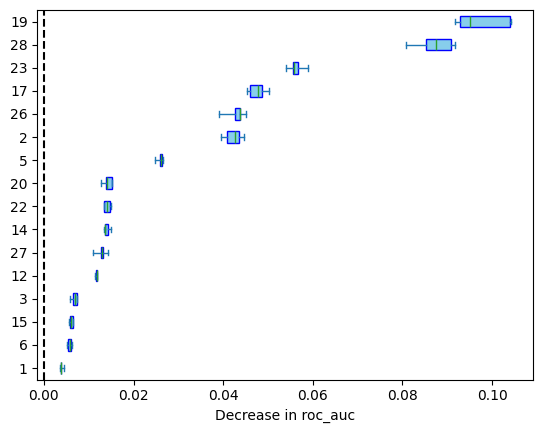

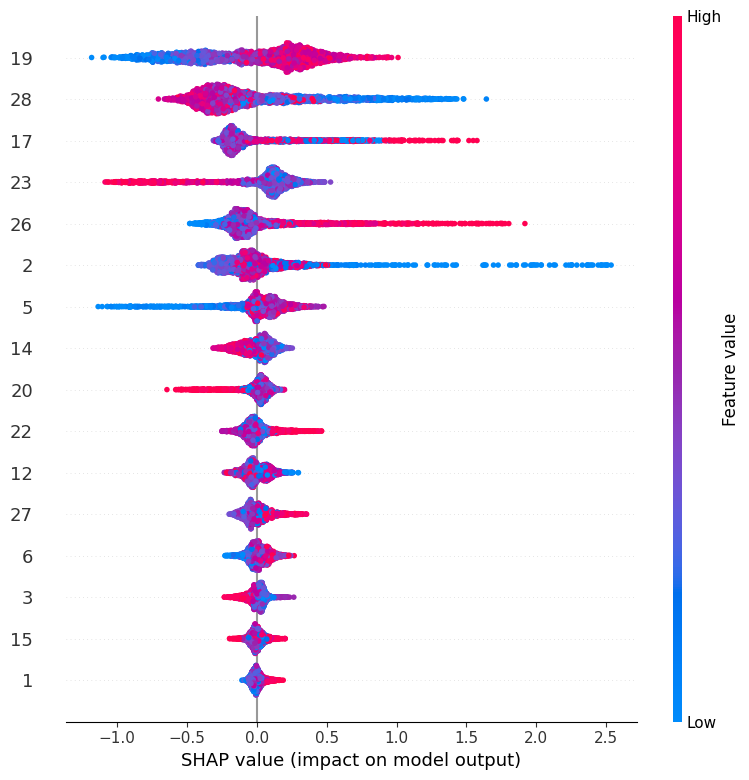

In [11]:
lgbm.analyze()

## CatBoost

In [12]:
cat = AutoMLClassifierCV(model_name='CatBoost', tune=True, cv=StratifiedKFold(3), scoring='brier')
cat.train(X_train, y_train, X_test, y_test)

In [15]:
cat.get_metrics()

,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,LogLoss
Train CV,0.68713,0.813823,0.404308,0.539968,0.813977,NaN,0.127325,0.414233
Test,0.70302,0.780142,0.447154,0.568475,0.808997,0.524843,0.128785,0.418555


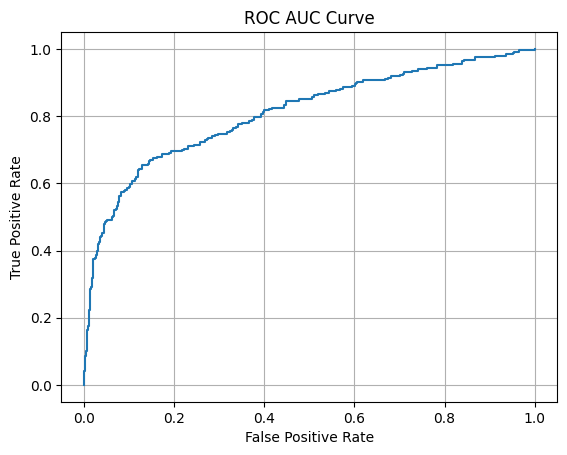

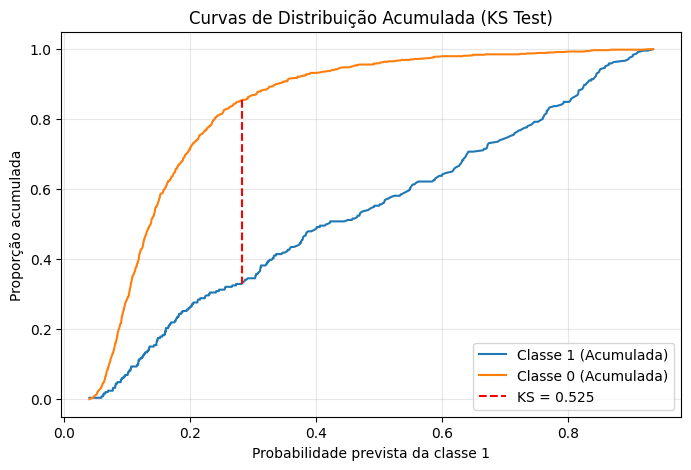

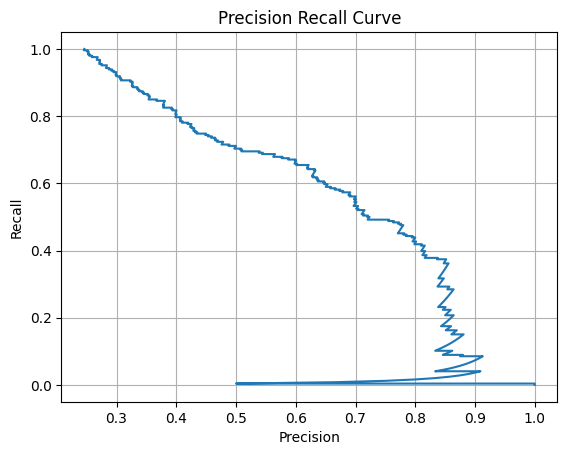

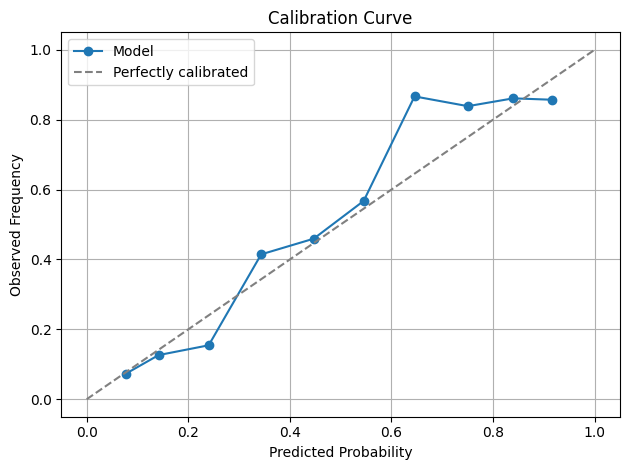

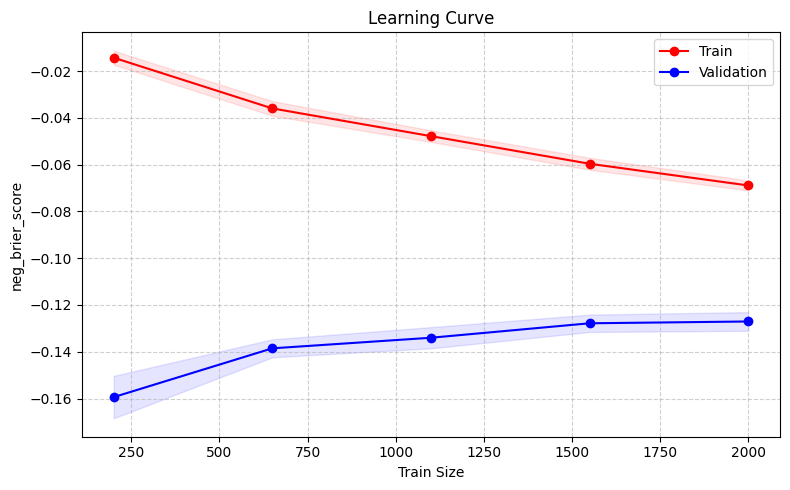

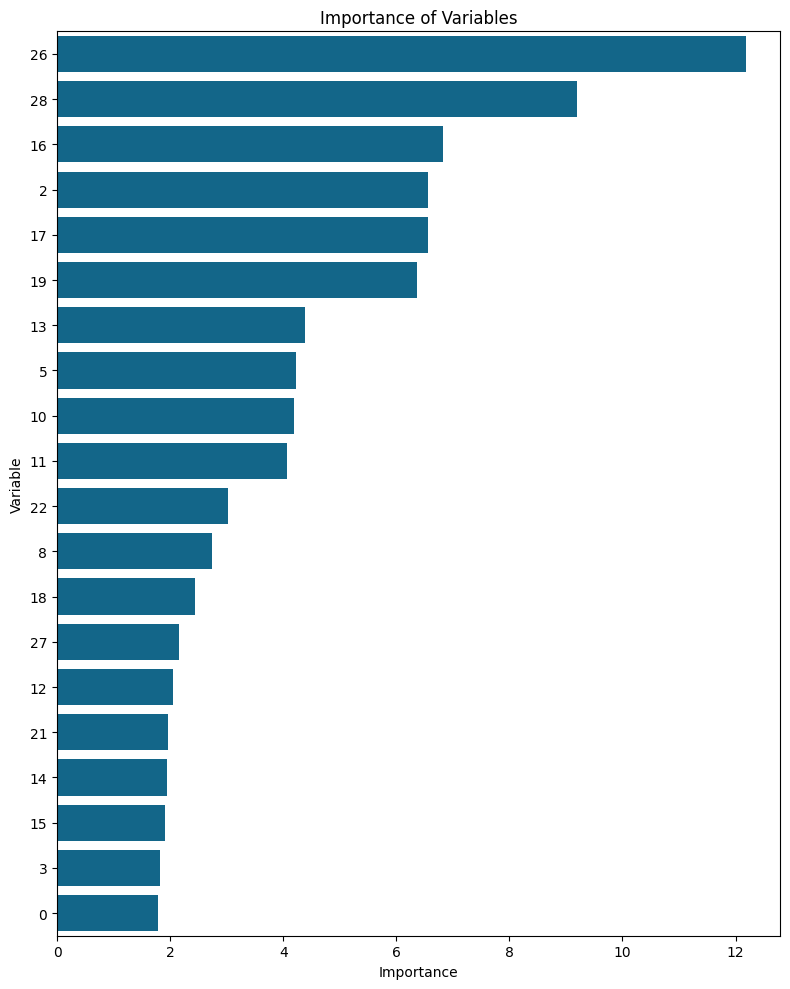

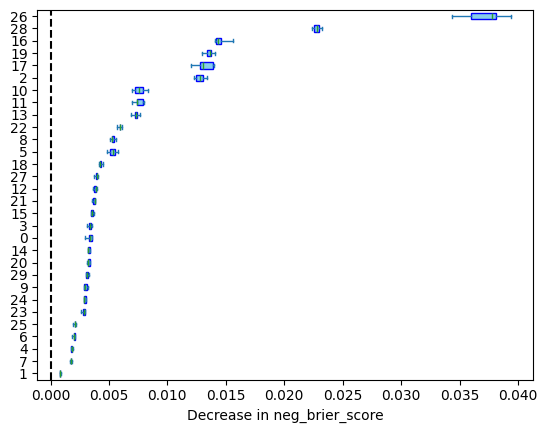

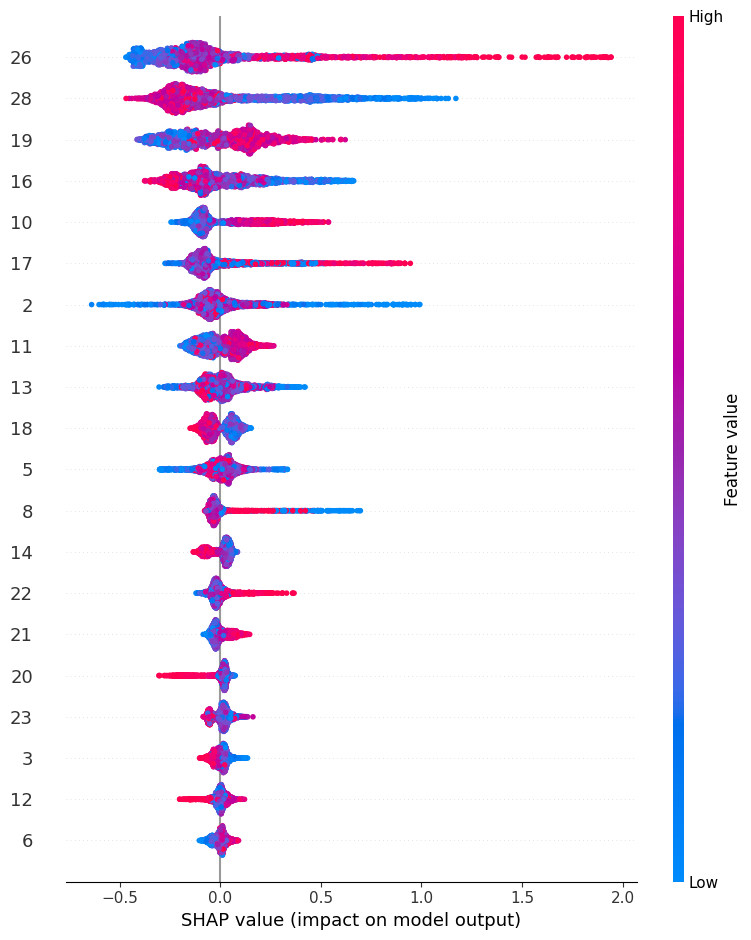

In [16]:
cat.analyze()